<a href="https://colab.research.google.com/github/RAbadiaH/forecasting-through-deep-learning-and-modal-decomposition-in-multi-phase-concentric-jets/blob/main/rnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

################################################################################

**This notebook uses the GPU accelerator. To configure this go to "Edit -> Notebook settings"**

**To run all cells at once go to "Runtime -> Run All"**

################################################################################

# Clone Github repository

In [1]:
!git clone https://github.com/RAbadiaH/forecasting-through-deep-learning-and-modal-decomposition-in-multi-phase-concentric-jets.git

Cloning into 'forecasting-through-deep-learning-and-modal-decomposition-in-multi-phase-concentric-jets'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 6), reused 5 (delta 1), pack-reused 4
Unpacking objects: 100% (20/20), 101.82 MiB | 7.07 MiB/s, done.


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import collections
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime, time
import scipy
import scipy.io
import seaborn as sns


import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
import pandas.core.algorithms as algos
from pandas import Series
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.neural_network import MLPClassifier

In [3]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    epsilon = 1e-10 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon,np.abs(y_true)))) * 100

In [5]:
def smape(A, F):
    return ((100.0/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))+ np.finfo(float).eps))

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, dot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Reshape, BatchNormalization, TimeDistributed, \
                         Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.backend import abs

from tensorflow.keras.layers import Dense, Dropout, Flatten, dot, Permute, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D

from tensorflow.keras.layers import add, ConvLSTM2D


In [7]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [8]:
# set working directory
import os

# Data Loading

In [9]:
!ls

forecasting-through-deep-learning-and-modal-decomposition-in-multi-phase-concentric-jets
sample_data


In [10]:
!ls forecasting-through-deep-learning-and-modal-decomposition-in-multi-phase-concentric-jets

Normal_MONO_sim.mat  Normal_STS_sim.mat  README.md  rnn_model.ipynb


In [11]:
dic_name = 'forecasting-through-deep-learning-and-modal-decomposition-in-multi-phase-concentric-jets/'

f = scipy.io.loadmat(dic_name + 'Normal_MONO_sim.mat'); Normal_MONO_sim = f.get('Normal_MONO_sim')

f = scipy.io.loadmat(dic_name + 'Normal_STS_sim.mat'); Normal_STS_sim = f.get('Normal_STS_sim')

In [12]:
Tensor_MONO = Normal_MONO_sim

Tensor_orig = Normal_STS_sim - Tensor_MONO
tensor = Tensor_orig

Name = "Normal_STS_sim"

# Reduction of tensor dimension



In [13]:
tensor = tensor[:,:,0::2,:]
Tensor_MONO = Tensor_MONO[:,:,0::2,:]
print(tensor.shape)
print(Tensor_MONO.shape)

(1, 100, 100, 351)
(1, 100, 100, 351)


In [14]:
min_val = np.amin(tensor)
max_val = np.amax(tensor)
range_val = np.ptp(tensor)
std_val =np.std(tensor)
print(min_val, max_val)
print(range_val) # rango de valores
print(std_val)

-0.6362509915434705 1.7545168734485117
2.3907678649919823
0.1874235507143572


# Data Normalization

In [15]:
# We do not normalize the data in this model
min_val = 0
range_val = 1
tensor_norm = (tensor-min_val)/range_val
scipy.stats.describe(tensor_norm.flatten())

DescribeResult(nobs=3510000, minmax=(-0.6362509915434705, 1.7545168734485117), mean=0.06618331079426397, variance=0.03512759737023978, skewness=3.147073294251095, kurtosis=16.951266045788046)

## Dimensiones del dataset

In [16]:
total_length = tensor_norm.shape[3]
channels_n = tensor_norm.shape[0]
dim_x = tensor_norm.shape[1]
dim_y = tensor_norm.shape[2]

print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)

total_length:  351
channels_n:  1
dim_x:  100
dim_y:  100


## Preparar data generator y datos de test (ejecutar en esta version)

In [17]:
import math
class DataGenerator(tf.keras.utils.Sequence): 
    'Generates data for Keras'
    def __init__(self, data, list_IDs, batch_size=5, dim=(2,35,50), 
                 k = 624, p = 1, 
                 shuffle=True, till_end = False, only_test = False):
        'Initialization'
        self.data = data
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.p = p
        self.k = k
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.till_end:
          lenx = math.ceil((len(self.list_IDs) / self.batch_size))
        else:
          lenx = int(np.floor(len(self.list_IDs) / self.batch_size))
        return lenx

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
          return X
        else:
          return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, depth)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.k))
        y = [np.empty((self.batch_size, *self.dim))]*self.p

        y_inter = np.empty((self.batch_size, *self.dim, p))

        # Generate data
        lenn = len(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store Xtrain
            X[i,:,:,:,:] = self.data[:,:,:,ID:ID+k]
            # Store Ytrain
            y_inter[i,:,:,:,:] = self.data[:,:,:,ID+k:ID+k+p] 

        for j in range(self.p):
          y[j] = y_inter[:,:,:,:,j]
          y[j] = np.reshape(y[j], (lenn, -1)) 

        X = X.transpose((0,4,2,3,1))
        X = np.reshape(X, (X.shape[0],X.shape[1],-1))

        return X, y

In [18]:
# Prepare data generators

period_transitorio = 0
stride_train = 2
stride_val = 1
stride_test = 1
test_prop = 0.35
val_prop = 0.2

batch_size=5
dim=(channels_n, dim_x, dim_y)
k = 10
p = 2



test_length = int(test_prop * total_length)
val_length  = int((total_length - test_length) * val_prop)
train_length = total_length - val_length - test_length
    
if int(train_length-period_transitorio-(k+p)) < 0:
    train_n = 0
elif int((train_length-period_transitorio-(k+p))//stride_train) == 0:
    train_n = 1
else: 
    train_n = int(((train_length-period_transitorio)-(k+p))//stride_train) + 1
    
if int(test_length-(k+p)) < 0:
    test_n = 0
elif int((test_length-(k+p))//stride_test) == 0:
    test_n = 1
else: 
    test_n = int((test_length-(k+p))//stride_test) + 1

if int(val_length-(k+p)) < 0:
    val_n = 0
elif int((val_length-(k+p))//stride_val) == 0:
    val_n = 1
else: 
    val_n = int((val_length-(k+p))//stride_val) + 1

# Starting index of each batch
train_idxs = np.empty([train_n], dtype='int')
val_idxs = np.empty([val_n], dtype='int')
test_idxs = np.empty([test_n], dtype='int')

j = period_transitorio
for i in range(train_n):
    train_idxs[i] = j
    j = j+stride_train

j = train_length
for i in range(val_n):
    val_idxs[i] = j
    j = j+stride_val

j = train_length + val_length
for i in range(test_n):
    test_idxs[i] = j
    j = j+stride_test



# Generators
training_generator = DataGenerator(tensor_norm, train_idxs,  
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = False,
                                    shuffle = True)
validation_generator = DataGenerator(tensor_norm, val_idxs, 
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = False,
                                    shuffle = False)
test_generator = DataGenerator(tensor_norm, test_idxs, 
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = True,
                                    shuffle = False)
mono_generator = DataGenerator(Tensor_MONO, test_idxs, 
                                    dim = dim, 
                                    batch_size = batch_size,
                                    k = k, p = p, till_end = False,
                                    only_test = True,
                                    shuffle = False)

print ('test_length: ', test_length)
print ('val_length: ', val_length)
print ('train_length: ', train_length)
print()
print ('test_n: ', test_n)
print ('val_n: ', val_n)
print ('train_n: ', train_n)
print()
print('test_generator_len: ', len(test_generator))
print('validation_generator_len: ', len(validation_generator))
print('training_generator_len: ', len(training_generator))

test_length:  122
val_length:  45
train_length:  184

test_n:  111
val_n:  34
train_n:  87

test_generator_len:  22
validation_generator_len:  6
training_generator_len:  17


In [19]:
# Prepare Ytest
test_n_adjusted = int(test_n/batch_size)*batch_size
Ytest = [np.empty([test_n_adjusted, channels_n, dim_x, dim_y], dtype='float64')] * p
Ytest_fl = [np.empty([test_n_adjusted, channels_n * dim_x * dim_y ], dtype='float64')] * p

Ytest_inter = np.empty([test_n_adjusted, channels_n, dim_x, dim_y, p], dtype='float64')

for i in range(test_n_adjusted):
    j = test_idxs[i]
    Ytest_inter[i,:,:,:,:] = tensor_norm[:,:,:,j+k:j+k+p]

for r in range(p):    
  Ytest[r] = Ytest_inter[:,:,:,:,r]
  Ytest_fl[r] = np.copy(np.reshape(Ytest[r], (test_n_adjusted, -1)) )

print(len(Ytest_fl))
print(len(Ytest))
print(Ytest_fl[0].shape)
print(Ytest[0].shape)

2
2
(110, 10000)
(110, 1, 100, 100)


In [20]:
# Prepare Mono tensor
test_n_adjusted = int(test_n/batch_size)*batch_size
YMONOtest = [np.empty([test_n_adjusted, channels_n, dim_x, dim_y], dtype='float64')] * p
YMONOtest_fl = [np.empty([test_n_adjusted, channels_n * dim_x * dim_y ], dtype='float64')] * p

YMONOtest_inter = np.empty([test_n_adjusted, channels_n, dim_x, dim_y, p], dtype='float64')

for i in range(test_n_adjusted):
    j = test_idxs[i]
    YMONOtest_inter[i,:,:,:,:] = Tensor_MONO[:,:,:,j+k:j+k+p]

for r in range(p):    
  YMONOtest[r] = YMONOtest_inter[:,:,:,:,r]
  YMONOtest_fl[r] = np.copy(np.reshape(YMONOtest[r], (test_n_adjusted, -1)) )

print(len(YMONOtest_fl))
print(len(YMONOtest))
print(YMONOtest_fl[0].shape)
print(YMONOtest[0].shape)

2
2
(110, 10000)
(110, 1, 100, 100)


## Preparar modelo

In [21]:
tf.keras.backend.clear_session()

In [22]:
np.random.seed(2453115889)
#tf.random.set_seed(322198573)

In [23]:
def create_model(in_shape,  out_dim, p = 3, shared_dim = 1000, act_fun= 'relu'):
    x = Input(shape=in_shape)
    Fm = Input(shape=in_shape)
    
    v = LSTM(400)(x)
    v = Dense(p*100, activation= act_fun)(v)
    v = Reshape((p,100))(v)

    tt = [1]*p
    
    r = TimeDistributed( Dense(shared_dim, activation=act_fun))(v)
    s = tf.split(r, tt, 1)
    for i in range(p):
      s[i] = Flatten()(s[i])

    o = []
    for i in range(p):
      #o.append( Dense(out_dim, activation='sigmoid')(s[i]) )
      o.append( Dense(out_dim, activation=None)(s[i]) )
  
    m = Model(inputs=x, outputs=o)
    m.compile(loss='mse', optimizer='adam', metrics=['mse'])
    #m.compile(loss='mae', optimizer='adam', metrics=['mae'])
    return(m)

In [24]:
#crear modelo

in_shape = [k, dim_x * dim_y * channels_n]
out_dim = dim_x * dim_y * channels_n 
shared_dim = 80
print(in_shape)
print(out_dim)
print(shared_dim)


model= create_model(in_shape,out_dim,p,shared_dim) 

[10, 10000]
10000
80


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10000)]  0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 400)          16641600    ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 200)          80200       ['lstm[0][0]']                   
                                                                                                  
 reshape (Reshape)              (None, 2, 100)       0           ['dense[0][0]']                  
                                                                                              

In [26]:
# save the best weights 
import sys
save_string = "colab_UPM_RNN_model"

# save the best weights 
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'

print(save_string)

colab_UPM_RNN_model


# Entrenamiento

In [27]:
np.random.seed(247531338)

In [28]:
t0 = time.time()

callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True, mode='auto'),
             EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
            ]

# epochs
num_epochs = 140


history = model.fit(training_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=True,
                              workers=6,
                              max_queue_size=10,
                              epochs=num_epochs,
                              verbose=1,
                              callbacks=callbacks)
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))


Epoch 1/140
17/17 [==============================] - 17s 508ms/step - loss: 0.0491 - dense_2_loss: 0.0249 - dense_3_loss: 0.0242 - dense_2_mse: 0.0249 - dense_3_mse: 0.0242 - val_loss: 0.0156 - val_dense_2_loss: 0.0080 - val_dense_3_loss: 0.0076 - val_dense_2_mse: 0.0080 - val_dense_3_mse: 0.0076
Epoch 2/140
17/17 [==============================] - 9s 512ms/step - loss: 0.0172 - dense_2_loss: 0.0087 - dense_3_loss: 0.0085 - dense_2_mse: 0.0087 - dense_3_mse: 0.0085 - val_loss: 0.0090 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0046 - val_dense_2_mse: 0.0044 - val_dense_3_mse: 0.0046
Epoch 3/140
17/17 [==============================] - 7s 437ms/step - loss: 0.0140 - dense_2_loss: 0.0070 - dense_3_loss: 0.0070 - dense_2_mse: 0.0070 - dense_3_mse: 0.0070 - val_loss: 0.0081 - val_dense_2_loss: 0.0039 - val_dense_3_loss: 0.0042 - val_dense_2_mse: 0.0039 - val_dense_3_mse: 0.0042
Epoch 4/140
17/17 [==============================] - 7s 432ms/step - loss: 0.0125 - dense_2_loss: 0.0061 - d

In [41]:
# save the last weights 
model.save_weights(save_last_weights)

In [42]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [43]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [32]:
#summary_stats = pd.read_csv(save_summary_stats)
summary_stats.to_csv(save_summary_stats)    

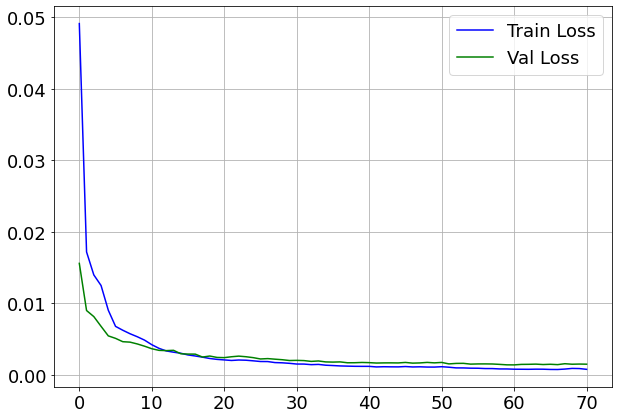



Minimum val_loss at epoch 61 = 0.0014


In [33]:
fig1 = plt.figure(figsize=(10,7))

plt.plot(summary_stats.train_loss, 'b') # blue
plt.plot(summary_stats.valid_loss, 'g') # green

figname = "LossComparation.eps"

plt.legend(["Train Loss", "Val Loss"])
#plt.savefig(figname, format='eps')

plt.grid(True, which='both')
plt.show()


# Find the min validation loss during the training
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print("\n")
print('Minimum val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)

# Testing

In [34]:
# Relative root mean square error
def RRMSE (real, predicted):
  a = np.linalg.norm((real-predicted), ord='fro')
  b = np.linalg.norm(real, ord='fro')
  return(a/b)

In [35]:
def RRMSE_flat (real, predicted):  
  a = np.linalg.norm((real-predicted).flatten(), ord=2)
  b = np.linalg.norm(real.flatten(), ord=2)
  return(a/b)

In [36]:
t0 = time.time()

model.load_weights(save_best_weights)
Ytest_hat_fl = model.predict(test_generator, max_queue_size=10, workers=6, use_multiprocessing=True, verbose=1)
    
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

22/22 [==============================] - 1s 24ms/step
Minutes elapsed: 0.105104


In [37]:
print('Performance measures on Test data, for all time, per time-ahead lag')

results_table_global = pd.DataFrame(index=['MSE','MAE','MAD','R2','SMAPE','RRMSE', 'RRMSE_FLAT'],columns=range(p))
for i in range(p):
    results_table_global.iloc[0,i] = mean_squared_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[1,i] = mean_absolute_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[2,i] = median_absolute_error(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[3,i] = r2_score(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[4,i] = smape(Ytest_fl[i].flatten(), Ytest_hat_fl[i].flatten())
    results_table_global.iloc[5,i] = RRMSE( np.reshape(Ytest_fl[i].flatten(),(-1,1)), np.reshape(Ytest_hat_fl[i].flatten(),(-1,1)))
    results_table_global.iloc[6,i] = RRMSE_flat( np.reshape(Ytest_fl[i].flatten(),(-1,1)), np.reshape(Ytest_hat_fl[i].flatten(),(-1,1)))

results_table_global['mean'] = results_table_global.mean(axis=1)

savename = "Figures/"+ Name +"/LSTM/errors.csv"

#results_table_global.to_csv(savename, index=True)

results_table_global

Performance measures on Test data, for all time, per time-ahead lag


,0,1,mean
MSE,0.001117,0.001295,0.001206
MAE,0.023727,0.025478,0.024602
MAD,0.016972,0.018118,0.017545
R2,0.969436,0.964646,0.967041
SMAPE,52.606313,55.358473,53.982393
RRMSE,0.165799,0.178397,0.172098
RRMSE_FLAT,0.165799,0.178397,0.172098


In [38]:
custom_palette = sns.color_palette("coolwarm", 26)

# Plot predictions and ground truth snapshots
Play with different values for the parameter i (by default i=70). Do not modify the values for the parameter lag, where lag = 0 and lag = 1 are the two future predictions returned by the model.

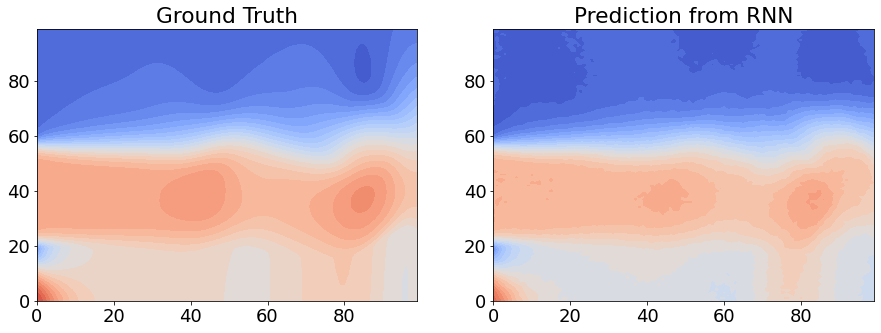

In [39]:
i = 70
lag = 0

Ytest_hat_lag = np.reshape(Ytest_hat_fl[lag], (Ytest[lag].shape[0],Ytest[lag].shape[1],Ytest[lag].shape[2],Ytest[lag].shape[3]))
Ytest_lag = np.reshape(Ytest_fl[lag], (Ytest[lag].shape[0],Ytest[lag].shape[1],Ytest[lag].shape[2],Ytest[lag].shape[3]))

YMONOtest_lag = np.reshape(YMONOtest_fl[lag], (YMONOtest[lag].shape[0],YMONOtest[lag].shape[1],YMONOtest[lag].shape[2],YMONOtest[lag].shape[3]))

plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
plt.contourf((Ytest_lag*range_val + min_val)[i,0,:,:]+YMONOtest_lag[i,0,:,:], 25, colors = custom_palette)
plt.title('Ground Truth')
plt.subplot(1,2, 2)
plt.contourf((Ytest_hat_lag*range_val + min_val)[i,0,:,:]+YMONOtest_lag[i,0,:,:], 25, colors = custom_palette)
plt.title('Prediction from RNN')
plt.show()

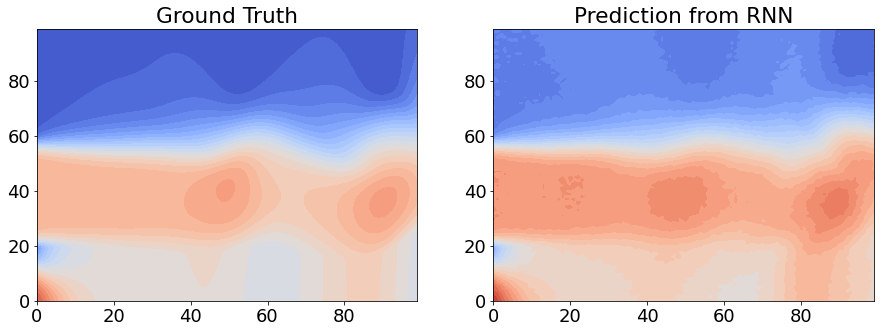

In [40]:
i = 70
lag = 1

Ytest_hat_lag = np.reshape(Ytest_hat_fl[lag], (Ytest[lag].shape[0],Ytest[lag].shape[1],Ytest[lag].shape[2],Ytest[lag].shape[3]))
Ytest_lag = np.reshape(Ytest_fl[lag], (Ytest[lag].shape[0],Ytest[lag].shape[1],Ytest[lag].shape[2],Ytest[lag].shape[3]))

YMONOtest_lag = np.reshape(YMONOtest_fl[lag], (YMONOtest[lag].shape[0],YMONOtest[lag].shape[1],YMONOtest[lag].shape[2],YMONOtest[lag].shape[3]))

plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
plt.contourf((Ytest_lag*range_val + min_val)[i,0,:,:]+YMONOtest_lag[i,0,:,:], 25, colors = custom_palette)
plt.title('Ground Truth')
plt.subplot(1,2, 2)
plt.contourf((Ytest_hat_lag*range_val + min_val)[i,0,:,:]+YMONOtest_lag[i,0,:,:], 25, colors = custom_palette)
plt.title('Prediction from RNN')
plt.show()